In [2]:
import numpy as np
import pandas as pd


import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from skimage import measure, io
from skimage.filters import threshold_otsu, sobel
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line, rotate)
from skimage.feature import canny
from skimage.morphology import binary_dilation
from scipy.stats import mode
import math
import sys
from scipy import misc



original shape: (512, 512)


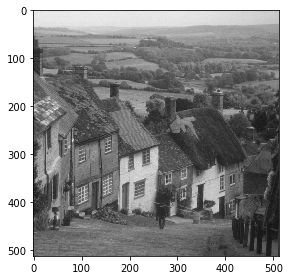

scaled shape: [1126 1126]


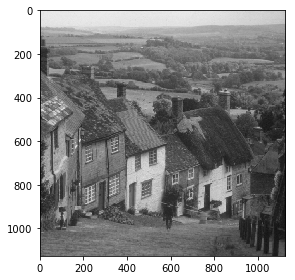

In [43]:
files = [
    'baboon.png',
    'butterfly.png',
    'city.png',
    'house.png',
    'seagull.png',
]

scale = 2.2
f = files[2]
original_img = misc.imread(f)
print("original shape:", original_img.shape)
io.imshow(original_img)
plt.show()


scaled_shape = np.floor(np.multiply(original_img.shape, scale)).astype(int)
print("scaled shape:", scaled_shape)
scaled_img = np.zeros(scaled_shape)

# scale
indexes = np.indices(scaled_shape)
indexes = np.round(indexes / scale).astype(int)

# interpolation
x_indexes = indexes[0].flatten()
y_indexes = indexes[1].flatten()
scaled_img = original_img[x_indexes, y_indexes].reshape(scaled_shape)

# save scaled image
io.imsave('scaled1.' + f, scaled_img)
io.imshow(scaled_img)
plt.show()


In [39]:
original_img.shape 



(512, 512)

original shape: (512, 512)


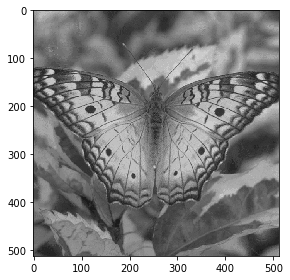

scaled shape: [256 256]


/Users/tanakaed/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: scaled2.butterfly.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/tanakaed/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


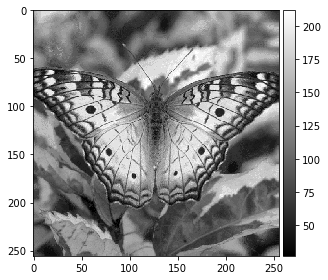

In [66]:
scale = 0.5
f = files[1]
original_img = misc.imread(f)
print("original shape:", original_img.shape)
io.imshow(original_img)
plt.show()

scaled_shape = np.floor(np.multiply(original_img.shape, scale)).astype(int)
print("scaled shape:", scaled_shape)
scaled_img = np.zeros(scaled_shape)

# scale
indexes = np.indices(scaled_shape)
indexes[0] = np.clip(indexes[0], 0, scaled_shape[0] - 2)
indexes[1] = np.clip(indexes[1], 0, scaled_shape[1] - 2)
indexes = np.floor(indexes / scale).astype(int)
dx_dy = (indexes / scale) - np.floor(indexes / scale)
# x_indexes = indexes[0].flatten()
# y_indexes = indexes[1].flatten()
term1 = (1 - dx_dy[0]) * (1 - dx_dy[1]) * original_img[indexes[0], indexes[1]]
term2 = (dx_dy[0]) * (1 - dx_dy[1]) * original_img[indexes[0] + 1, indexes[1]]
term3 = (1 - dx_dy[0]) * (dx_dy[1]) * original_img[indexes[0], indexes[1] + 1]
term4 = (dx_dy[0]) * (dx_dy[1]) * original_img[indexes[0] + 1, indexes[1] + 1]

#TODO: treat range of gray color
scaled_img = np.round(term1 + term2 + term3 + term4).astype(int)
io.imsave('scaled2.' + f, scaled_img, cmap='gray')
io.imshow(scaled_img, cmap='gray')
plt.show()

original shape: (512, 512)
scaled shape: [1000 1000]
26
211


/Users/tanakaed/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: scaled3.butterfly.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/tanakaed/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


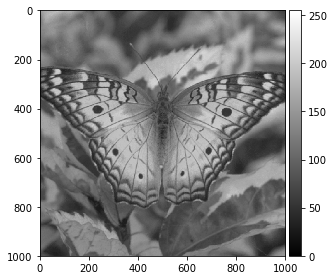

In [105]:
def R_function(s):
    return ((np.maximum(s + 2, 0)** 3) - 4*(np.maximum(s + 1, 0)**3) + 6*(np.maximum(s, 0)**3) - 4*(np.maximum(s - 1, 0)**3)) / 6

scale = 1.955
f = files[1]
original_img = misc.imread(f)
print("original shape:", original_img.shape)
# io.imshow(original_img)
# plt.show()

scaled_shape = np.floor(np.multiply(original_img.shape, scale)).astype(int)
print("scaled shape:", scaled_shape)
scaled_img = np.zeros(scaled_shape)

# scale
indexes = np.indices(scaled_shape)
indexes[0] = np.clip(indexes[0], 0, scaled_shape[0] - 1)
indexes[1] = np.clip(indexes[1], 0, scaled_shape[1] - 1)
indexes = np.floor(indexes / scale).astype(int)
dx_dy = (indexes / scale) - np.floor(indexes / scale)

for m in range(-1, 3):
    for n in range(-1, 3):
        dx = dx_dy[0]
        dy = dx_dy[1]
        r2 = R_function(m - dx)
        r1 = R_function(dy - n)
        x_indexes = np.clip(indexes[0] + m, 0, original_img.shape[0] - 1)
        y_indexes = np.clip(indexes[1] + n, 0, original_img.shape[1] - 1)
        scaled_img = scaled_img + (r1*r2*original_img[x_indexes, y_indexes])

scaled_img = scaled_img.astype(int)
print(np.amin(scaled_img))
print(np.amax(scaled_img))
io.imsave('scaled3.' + f, scaled_img, cmap='gray', vmin=0, vmax=255)
io.imshow(scaled_img, cmap='gray', vmin=0, vmax=255)
plt.show()

original shape: (512, 512)
scaled shape: [1000 1000]
20
220


/Users/tanakaed/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: scaled4.butterfly.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/tanakaed/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


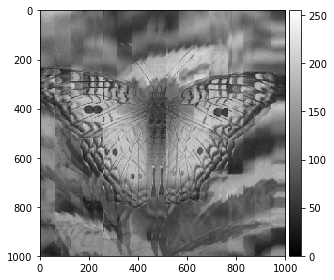

In [112]:
def L_function(n, dx, dy, indexes, original_img):
    width = original_img.shape[0] - 1
    height = original_img.shape[1] - 1
    x = indexes[0]
    y = np.clip(indexes[1] + n - 2, 0, height) # y + n - 2 
    l = (-dx * (dx-1) * (dx-2) * original_img[np.clip(x - 1, 0, width), y])/6
    l += ((dx+1) * (dx-1) * (dx-2) * original_img[x, y])/2
    l += (-dx * (dx+1) * (dx-2) * original_img[np.clip(x + 1, 0, width), y])/2
    l += (dx * (dx+1) * (dx-1) * original_img[np.clip(x + 2, 0, width), y])/6
    return l

scale = 1.955
f = files[1]
original_img = misc.imread(f)
print("original shape:", original_img.shape)
# io.imshow(original_img)
# plt.show()

scaled_shape = np.floor(np.multiply(original_img.shape, scale)).astype(int)
print("scaled shape:", scaled_shape)
scaled_img = np.zeros(scaled_shape)

# scale
indexes = np.indices(scaled_shape)
indexes = np.floor(indexes / scale).astype(int)
dx_dy = (indexes / scale) - np.floor(indexes / scale)
dx = dx_dy[0]
dy = dx_dy[1]

scaled_img = (-dy * (dy - 1) * (dy - 2) * L_function(1, dx, dy, indexes, original_img))/6
scaled_img += ((dy+1) * (dy - 1) * (dy - 2) * L_function(2, dx, dy, indexes, original_img))/2
scaled_img += (-dy * (dy + 1) * (dy - 2) * L_function(3, dx, dy, indexes, original_img))/2
scaled_img += (dy * (dy + 1) * (dy - 1) * L_function(4, dx, dy, indexes, original_img))/6

scaled_img = scaled_img.astype(int)
print(np.amin(scaled_img))
print(np.amax(scaled_img))
io.imsave('scaled4.' + f, scaled_img, cmap='gray', vmin=0, vmax=255)
io.imshow(scaled_img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [108]:
a = np.random.random((1000, 1000))
a += 1
a

array([[ 1.17497656,  1.63743427,  1.56362159, ...,  1.30487962,
         1.77636427,  1.52739215],
       [ 1.66391389,  1.86779419,  1.18928367, ...,  1.56955205,
         1.78108874,  1.30826236],
       [ 1.00464126,  1.12400369,  1.70266801, ...,  1.53064242,
         1.34253676,  1.52408765],
       ..., 
       [ 1.61035305,  1.13821497,  1.12526038, ...,  1.3532221 ,
         1.03952125,  1.78913114],
       [ 1.07028924,  1.94476679,  1.40368589, ...,  1.58989527,
         1.21473217,  1.00291846],
       [ 1.68846802,  1.15917856,  1.57717217, ...,  1.48498372,
         1.50534169,  1.09030699]])

In [22]:
y_indexes.shape

(1267876,)

In [60]:
np.indices((2, 3))[1]

array([[0, 1, 2],
       [0, 1, 2]])